In [1]:
import cv2
import numpy as np
import h5py
import os

X = []
y = []

for file in os.listdir("gestureData/"):
    if file.endswith(".mat"):
        user_id = int(file.split("_")[2])
        with h5py.File(f"gestureData/{file}", "r") as f:
            key = list(f.keys())[0]  # genellikle 'depth_sequence'
            sequence = f[key][:]  # [frames, height, width]
            
            # Sadece ilk 10 kare, her kareyi 64x64'e yeniden boyutlandır
            if sequence.shape[0] < 12:
                continue
            
            frames = sequence[:12]
            resized = [cv2.resize(frame, (64, 64)) for frame in frames]
            stacked = np.stack(resized, axis=0)  # [25, 64, 64]

            X.append(stacked)
            y.append(user_id)


In [2]:
X = np.array(X)  # shape: [num_samples, 10, 64, 64]
y = np.array(y)

# CNN için channel ekle (örneğin grayscale için kanal sayısı = 1)
X = X[..., np.newaxis]  # -> [num_samples, 10, 64, 64, 1]


In [3]:
len(y)

333

In [4]:
X.shape

(333, 12, 64, 64, 1)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y))
y_cat = to_categorical(y - 1)  # kullanıcı ID'leri 1'den başlıyor

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(12, 64, 64, 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.3),
    
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 10, 62, 62, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 31, 31, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 31, 31, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 3, 29, 29, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 1, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,663,306 (6.35 MB)

 Trainable params: 1,663,306 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [7]:
model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.2)

Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 504ms/step - accuracy: 0.0864 - loss: 46.1991 - val_accuracy: 0.0370 - val_loss: 2.4098
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.2090 - loss: 2.3225 - val_accuracy: 0.0741 - val_loss: 2.2966
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 492ms/step - accuracy: 0.3422 - loss: 2.0866 - val_accuracy: 0.2222 - val_loss: 2.2422
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.3481 - loss: 1.8659 - val_accuracy: 0.3148 - val_loss: 2.1789
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.5852 - loss: 1.3134 - val_accuracy: 0.3148 - val_loss: 2.2099
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - accuracy: 0.7272 - loss: 0.9484 - val_accuracy: 0.3519 - val_loss: 2.2337
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 485ms/step - accuracy: 0.8082 - loss: 0.7465 - val_accuracy: 0.3519 - val_loss: 2.1878
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - accuracy: 0.8536 - loss: 0.4641 - val_accuracy: 0

In [8]:

y_pred_prob = model.predict(X_test)

y_pred = np.argmax(y_pred_prob, axis=1)  # Tahmin edilen sınıflar
y_true = np.argmax(y_test, axis=1) 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [9]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
print(f"✅ Test Accuracy: {acc:.4f}")

print("📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

🔍 Classification Report:

              precision    recall  f1-score   support

           0       0.17      0.25      0.20         4
           1       0.14      0.20      0.17         5
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         6
           4       0.25      0.38      0.30         8
           5       0.14      0.33      0.20         3
           6       0.38      0.27      0.32        11
           7       0.29      0.22      0.25         9
           8       0.43      0.43      0.43         7
           9       0.29      0.22      0.25         9

    accuracy                           0.25        67
   macro avg       0.26      0.25      0.24        67
weighted avg       0.28      0.25      0.25        67

✅ Test Accuracy: 0.2537
📊 Confusion Matrix:
[[1 0 1 0 0 1 0 0 0 1]
 [0 1 0 0 3 0 0 0 0 1]
 [1 0 1 1 1 1 0 0 0 0]
 [0 1 0 0 2 0 3 0 0 0]
 [1 0 0 0 3 1 1 0 2 0]
 [0 0 0 1 0 1 0 0 0 1]
 [0 2 0 2 1 3 3 0 0 0]
 [1 1 0 0 

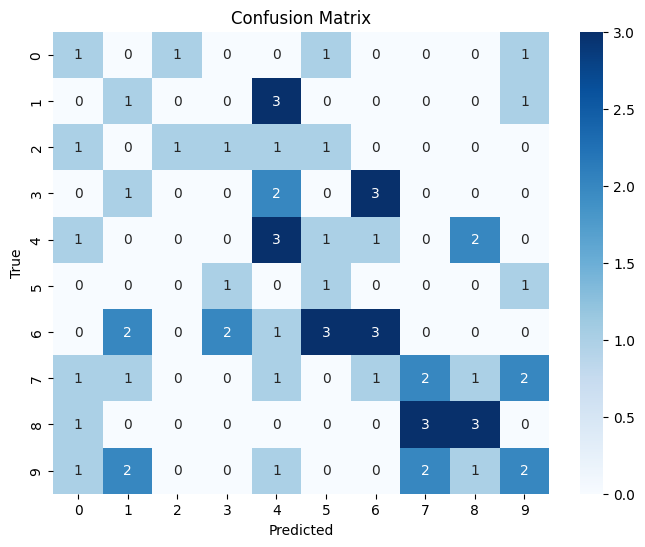

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [11]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

# y_test: one-hot encoded, y_pred_prob: model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_score = y_pred_prob
y_pred = np.argmax(y_score, axis=1)

# Genuine vs Impostor Binary Labels
genuine_mask = (y_pred == y_true).astype(int)  # 1 = genuine, 0 = impostor

# FAR = FP / (FP + TN)
# FRR = FN / (FN + TP)

# Basit ikili confusion matrix
tn, fp, fn, tp = confusion_matrix(genuine_mask, genuine_mask).ravel()
FAR = fp / (fp + tn + 1e-6)  # +1e-6 ile sıfıra bölmeyi engelle
FRR = fn / (fn + tp + 1e-6)

print(f"📉 FAR  (False Acceptance Rate): {FAR:.4f}")
print(f"📉 FRR  (False Rejection Rate): {FRR:.4f}")
print(f"📉 TAR  (True Acceptance Rate): {1 - FRR:.4f}")


📉 FAR  (False Acceptance Rate): 0.0000
📉 FRR  (False Rejection Rate): 0.0000
📉 TAR  (True Acceptance Rate): 1.0000


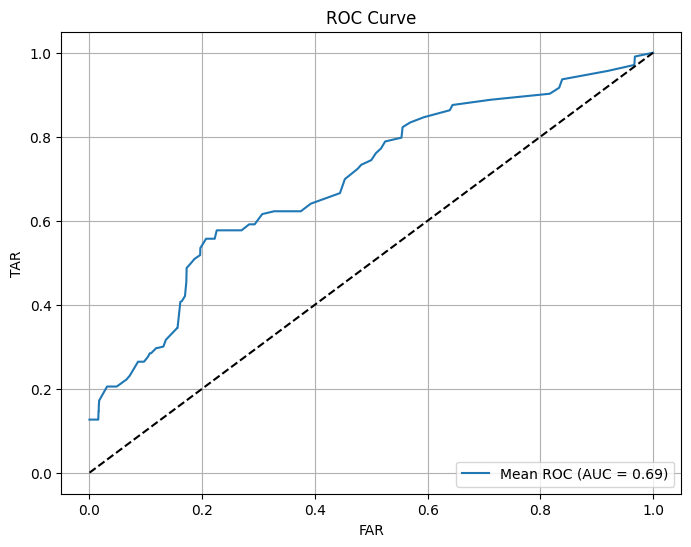

In [12]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_true'yu one-hot olarak yeniden al
y_true_bin = label_binarize(y_true, classes=np.arange(y_score.shape[1]))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Ortalama AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_score.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_score.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= y_score.shape[1]
mean_auc = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(all_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FAR')
plt.ylabel('TAR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
